<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_13%5DMovie_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_13]Movie recommendations

이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.

## 1. Import 및 라이브러리 다운로드

In [ ]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import scipy
import implicit
import pandas as pd

## 2. 데이터 준비와 전처리

### 1) 데이터 불러오기 및 ratings 3점 이상만 남기기

In [ ]:
rating_file_path = '/content/drive/MyDrive/인공지능/아이펠/ES/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [ ]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [ ]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [ ]:
movie_file_path= '/content/drive/MyDrive/인공지능/아이펠/ES/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### 2) 데이터 프레임 합치기
- https://yganalyst.github.io/data_handling/Pd_12/
  - 데이터에 존재하는 고유값을 기준으로 병합하는 merge() 사용
    - 기준은 둘다 공통으로 있는 movie_id로 지정하여 병합
    - how는 outter로 주어 어느 한쪽에라도 없는 데이터가 있는 경우 NaN값이 지정되게 함

In [ ]:
movies_data = pd.merge(ratings, movies, how='outer', on='movie_id' )
movies_data.drop(columns=['timestamp','genre'], axis=1, inplace=True)

In [ ]:
movies_data

,user_id,movie_id,counts,title
0,1.0,1193,5.0,One Flew Over the Cuckoo's Nest (1975)
1,2.0,1193,5.0,One Flew Over the Cuckoo's Nest (1975)
2,12.0,1193,4.0,One Flew Over the Cuckoo's Nest (1975)
3,15.0,1193,4.0,One Flew Over the Cuckoo's Nest (1975)
4,17.0,1193,5.0,One Flew Over the Cuckoo's Nest (1975)
...,...,...,...,...
836728,NaN,3829,NaN,Mad About Mambo (2000)
836729,NaN,3856,NaN,Autumn Heart (1999)
836730,NaN,3891,NaN,Turn It Up (2000)
836731,NaN,3904,NaN,"Uninvited Guest, An (2000)"


### 3) 데이터 확인 및 결측치 제거

In [ ]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836733 entries, 0 to 836732
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   836478 non-null  float64
 1   movie_id  836733 non-null  int64  
 2   counts    836478 non-null  float64
 3   title     836733 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 31.9+ MB


In [ ]:
movies_data.describe()

,user_id,movie_id,counts
count,836478.000000,836733.000000,836478.000000
mean,3033.120626,1849.105342,3.958293
std,1729.255651,1091.865588,0.762280
min,1.000000,1.000000,3.000000
25%,1531.000000,1029.000000,3.000000
50%,3080.000000,1747.000000,4.000000
75%,4485.000000,2763.000000,5.000000
max,6040.000000,3952.000000,5.000000


In [ ]:
movies_data.isnull().sum()

user_id     255
movie_id      0
counts      255
title         0
dtype: int64

- user_id와 ratings, timestamp가 모두 255개의 결측치를 가지고 있다.
- 전체 데이터셋에 비해 굉장히 미미한 데이터량이니 제거하도록 한다.

In [ ]:
movies_data.dropna(inplace=True)

In [ ]:
movies_data.isnull().sum()

user_id     0
movie_id    0
counts      0
title       0
dtype: int64

## 3. 분석


### 1)  ratings에 있는 유니크한 영화 개수, ratings에 있는 유니크한 사용자 수, 가장 인기 있는 영화 30개(인기순) 확인

In [ ]:
movies_data['movie_id'].nunique()

3628

In [ ]:
movies_data['user_id'].nunique()

6039

In [ ]:
title_count = movies_data.groupby(['title', 'movie_id'])['user_id'].count()

title_count.sort_values(ascending=False).head(30)

title                                                  movie_id
American Beauty (1999)                                 2858        3211
Star Wars: Episode IV - A New Hope (1977)              260         2910
Star Wars: Episode V - The Empire Strikes Back (1980)  1196        2885
Star Wars: Episode VI - Return of the Jedi (1983)      1210        2716
Saving Private Ryan (1998)                             2028        2561
Terminator 2: Judgment Day (1991)                      589         2509
Silence of the Lambs, The (1991)                       593         2498
Raiders of the Lost Ark (1981)                         1198        2473
Back to the Future (1985)                              1270        2460
Matrix, The (1999)                                     2571        2434
Jurassic Park (1993)                                   480         2413
Sixth Sense, The (1999)                                2762        2385
Fargo (1996)                                           608         2371


### 2) 적절한 user_id 찾기
- 마지막 user_id가 6040이니 나의 user_id는 6041로 지정한다.

In [ ]:
movies_data['user_id'].sort_values(ascending=False).head(30)

656608    6040.0
281262    6040.0
617963    6040.0
121191    6040.0
627702    6040.0
57560     6040.0
798728    6040.0
223074    6040.0
818301    6040.0
601338    6040.0
428011    6040.0
634198    6040.0
417198    6040.0
305373    6040.0
106997    6040.0
446235    6040.0
636104    6040.0
233895    6040.0
826337    6040.0
549943    6040.0
262075    6040.0
542222    6040.0
353431    6040.0
461916    6040.0
221213    6040.0
783933    6040.0
43535     6040.0
38619     6040.0
627161    6040.0
152321    6040.0
Name: user_id, dtype: float64

### 4. 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [ ]:
# 영화 타이틀, user_id, counts, genre, movie_id필요
my_favorite = ['Matrix, The (1999)' , 'Men in Black (1997)' ,'Toy Story (1995)' ,'Terminator, The (1984)' ,'Sixth Sense, The (1999)']
my_movie_id = [2571, 1580, 1, 1240, 2762]

my_playlist = pd.DataFrame({'user_id' : [6041] *5, 'movie_id' : my_movie_id, 'title': my_favorite, 'counts':[30]*5})


if not movies_data.isin({'user_id':[6041]})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    movies_data = movies_data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

movies_data.tail(10)    # 잘 추가되었는지 확인해 봅시다'

,user_id,movie_id,counts,title
836473,5851.0,3607,5.0,One Little Indian (1973)
836474,5854.0,3026,4.0,Slaughterhouse (1987)
836475,5854.0,690,3.0,"Promise, The (Versprechen, Das) (1994)"
836476,5938.0,2909,4.0,"Five Wives, Three Secretaries and Me (1998)"
836477,5948.0,1360,5.0,Identification of a Woman (Identificazione di ...
0,6041.0,2571,30.0,"Matrix, The (1999)"
1,6041.0,1580,30.0,Men in Black (1997)
2,6041.0,1,30.0,Toy Story (1995)
3,6041.0,1240,30.0,"Terminator, The (1984)"
4,6041.0,2762,30.0,"Sixth Sense, The (1999)"


### 5. CSR matrix를 직접 만들어 봅시다.
- CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.

In [ ]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = movies_data['user_id'].unique()
title_unique = movies_data['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [ ]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx[6041])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(title_to_idx['Toy Story (1995)'])

6039
40


In [ ]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = movies_data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(movies_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    movies_data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = movies_data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(movies_data):
    print('title column indexing OK!!')
    movies_data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

movies_data

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,counts,title
0,0,1193,5.0,0
1,1,1193,5.0,0
2,2,1193,4.0,0
3,3,1193,4.0,0
4,4,1193,5.0,0
...,...,...,...,...
0,6039,2571,30.0,124
1,6039,1580,30.0,175
2,6039,1,30.0,40
3,6039,1240,30.0,200


- 참고자료 
  - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [ ]:
from scipy.sparse import csr_matrix

num_user = movies_data['user_id'].nunique()
num_title = movies_data['title'].nunique()

csr_movies_data = csr_matrix((movies_data.counts, (movies_data.user_id, movies_data.title)), shape= (num_user, num_title))
csr_movies_data

<6040x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## 6. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
- als(AlternatingLeastSquares) 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져있다.

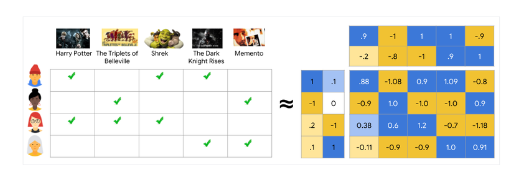

In [ ]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

> factors와 iterations를 늘릴수록 학습 데이터를 잘 학습하지만 과적합의 우려가 있으니 좋은 값을 찾아야 한다.

In [ ]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=80, regularization=0.01, use_gpu=False, iterations=10, dtype=np.float32)

In [ ]:
als_model.fit(csr_movies_data)

  0%|          | 0/10 [00:00<?, ?it/s]

## 7. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [ ]:
my_id, Men_in_black = user_to_idx[6041], title_to_idx['Men in Black (1997)']
my_id_vector, Men_in_black_vector = als_model.user_factors[my_id], als_model.item_factors[Men_in_black]

In [ ]:
my_id_vector

array([ 2.5892010e+00, -2.3596269e-01,  1.8098745e+00,  1.1739877e+00,
       -1.4589441e-01,  3.3934647e-01, -1.2463181e+00,  3.0845520e-01,
       -1.0820000e+00, -8.9602333e-01, -1.7459810e+00, -1.2056878e+00,
       -5.5738604e-01,  1.8875210e-01,  1.1808047e+00,  9.7032565e-01,
       -2.2095913e-01, -3.4900746e-01, -9.1499650e-01,  2.8162119e-01,
       -6.3729918e-01, -1.6385108e+00, -6.1292946e-01,  2.1116336e-01,
       -2.3576659e-01, -4.2763084e-02,  1.4977931e+00,  3.8308266e-01,
       -2.3372846e+00, -1.2228397e+00, -6.2937224e-01, -1.4932435e+00,
        2.1332455e+00, -1.1716999e-01, -8.8661247e-01,  1.8547615e+00,
        2.0106807e+00,  2.0520527e+00,  4.3667355e-01,  2.5587001e-01,
       -3.9863747e-01,  3.9609718e-01, -1.6335795e+00,  8.3188874e-01,
        8.4388052e-04,  2.0179563e+00,  8.4312397e-01, -2.2113749e-01,
       -3.8453242e-01, -6.5969980e-01, -1.0513501e+00, -5.2771229e-01,
       -1.0470304e+00,  3.9340049e-01,  1.2713521e+00, -2.6848504e-01,
      

In [ ]:
Men_in_black_vector

array([ 0.03565502,  0.00276402,  0.01620053,  0.02758981, -0.01885544,
       -0.00544418, -0.01938982,  0.00446083, -0.00294405,  0.00912016,
        0.00244974, -0.01472235, -0.00078888,  0.02516087,  0.03498071,
        0.01280169,  0.00898542, -0.00423497,  0.00023395, -0.0041301 ,
        0.02245782, -0.00880944,  0.00808551, -0.00198917, -0.00283948,
       -0.00520552,  0.00058963, -0.00624382, -0.00599928,  0.01106238,
       -0.00912775,  0.02308134,  0.0334801 , -0.00699823, -0.02010268,
        0.03576301,  0.01966318,  0.01999781,  0.03723913, -0.00690056,
       -0.00110764,  0.02158307,  0.00346316,  0.0091003 ,  0.02344434,
        0.01587283,  0.01035438,  0.01397783, -0.0096817 ,  0.00021318,
       -0.01414625, -0.0235564 , -0.01343521,  0.01204442,  0.03452469,
        0.0207366 ,  0.02981858, -0.02686019,  0.03010784,  0.00885616,
       -0.01314334, -0.01799181, -0.00633346,  0.02550347,  0.01863832,
       -0.00682717,  0.01921283,  0.0014178 , -0.02299031, -0.02

- 첫번째 시도(LMS : factors=100, iteration=15)

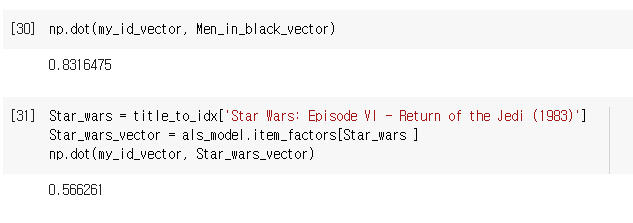

- 두번째 시도(factors=200, iteration=15)

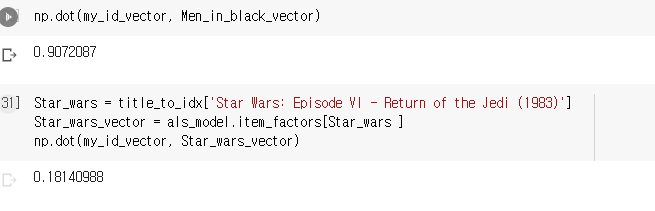

- 세번째 시도 (factors=150, iteration=20)

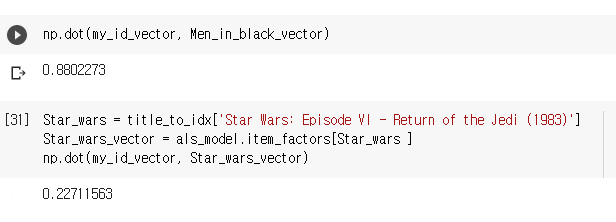

- 네번째 시도(factors=80, iteration=10)

In [ ]:
np.dot(my_id_vector, Men_in_black_vector)

0.83136016

In [ ]:
Star_wars = title_to_idx['Star Wars: Episode VI - Return of the Jedi (1983)']
Star_wars_vector = als_model.item_factors[Star_wars ]
np.dot(my_id_vector, Star_wars_vector)

0.5652188

> 정리
- 두번째, 세번째 시도
  - 많은 학습량과 높은 차원으로 과적합이 일어나 다른 영화 타이틀을 넣었을때 그 값이 현저히 떨어지는 것을 확인할 수 있다.
- 첫번째, 네번째 시도
  - 이는 과적합이 일어나지 않았다고 판단할 수 있다.
  - 첫번째, 네번째 시도 중에서 무엇을 사용할지 고민하였으나
  - 네번째 시도에서 가장 밑단 내가 좋아하는 추천에서 정말로 내가 어릴적 가장 좋아해서 많이 보던 영화가 포진해 있었다. 
  - 특히 내가 좋아하는 영화에 일부러 스타워즈를 넣지 않았는데 사실 스타워즈 시지즈를 다 챙겨봤을 만큼 좋아하던 영화이다. 마지막 결과를 보면 스타워즈 시리즈 들이 포진해 있는 것을 확인할 수 있었다.
  - 그리고 첫번째 시도와 달리 내가 싫어하는 에일리언 이라는 영화가 빠져있다.

## 8. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [ ]:
favorite_title = 'Shakespeare in Love (1998)'
title_id = title_to_idx[favorite_title]
similar_title_idx, similar_title = als_model.similar_items(title_id, N=15)
 # lms에서는 그냥 튜플로 나오지만 이 버전에서는 리턴이 두개로 나옵니다 :)
print(similar_title_idx)
print(similar_title)
tuple_similar_title = [(similar_title_idx[i], similar_title[i]) for i in range(15)]
print('-'*75)
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in tuple_similar_title]

[ 126  110  170  271  613   99   40  381   50   38  204  301  243 3035
  757]
[1.         0.62388283 0.57814723 0.57599187 0.5097191  0.50170374
 0.48419094 0.47773516 0.45737767 0.45124558 0.4441706  0.4285
 0.42844304 0.41854522 0.41526556]
---------------------------------------------------------------------------


['Shakespeare in Love (1998)',
 'Groundhog Day (1993)',
 'Being John Malkovich (1999)',
 'Election (1999)',
 'Four Weddings and a Funeral (1994)',
 'American Beauty (1999)',
 'Toy Story (1995)',
 'Elizabeth (1998)',
 'Toy Story 2 (1999)',
 'Sixth Sense, The (1999)',
 'Clueless (1995)',
 'Rushmore (1998)',
 'Ghostbusters (1984)',
 'For Ever Mozart (1996)',
 'Full Monty, The (1997)']

In [ ]:
favorite_title = 'Men in Black (1997)'
title_id = title_to_idx[favorite_title]
similar_title_idx, similar_title = als_model.similar_items(title_id, N=15)
 # lms에서는 그냥 튜플로 나오지만 이 버전에서는 리턴이 두개로 나옵니다 :)
print(similar_title_idx)
print(similar_title)
tuple_similar_title = [(similar_title_idx[i], similar_title[i]) for i in range(15)]
print('-'*75)
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in tuple_similar_title]

[ 175  107   92   62  150  124  145   82  138   87   60  542  375  544
 1045]
[1.         0.8378379  0.67599976 0.61723715 0.54417896 0.5379254
 0.5335466  0.5079845  0.49242827 0.4918291  0.48979527 0.48747614
 0.47400454 0.4543645  0.44559687]
---------------------------------------------------------------------------


['Men in Black (1997)',
 'Jurassic Park (1993)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Independence Day (ID4) (1996)',
 'Matrix, The (1999)',
 'Fifth Element, The (1997)',
 'Lost World: Jurassic Park, The (1997)',
 'True Lies (1994)',
 'Braveheart (1995)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Rocky Horror Picture Show, The (1975)',
 'Face/Off (1997)',
 'Stargate (1994)',
 'Grumpy Old Men (1993)']

## 9. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

### 1) 영화 추천받기

In [ ]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
title_recommended_idx, title_recommended = als_model.recommend(user, csr_movies_data[user], N=15, filter_already_liked_items=True)
tuple_title_recommended = [(title_recommended_idx[i], title_recommended[i]) for i in range(15)]
tuple_title_recommended

[(92, 1.0910898),
 (107, 0.80228734),
 (62, 0.7512238),
 (141, 0.6718682),
 (50, 0.64975744),
 (44, 0.62332386),
 (110, 0.5999917),
 (670, 0.59044516),
 (22, 0.58263874),
 (64, 0.5652188),
 (60, 0.559483),
 (117, 0.54897124),
 (126, 0.5339569),
 (99, 0.5058538),
 (75, 0.48690656)]

In [ ]:
[idx_to_title[i[0]] for i in tuple_title_recommended]

['Terminator 2: Judgment Day (1991)',
 'Jurassic Park (1993)',
 'Total Recall (1990)',
 'Fugitive, The (1993)',
 'Toy Story 2 (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Groundhog Day (1993)',
 'Galaxy Quest (1999)',
 'Back to the Future (1985)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Shakespeare in Love (1998)',
 'American Beauty (1999)',
 'Hunt for Red October, The (1990)']

### 2) 추천에 기여한 정도

In [ ]:
Star = title_to_idx['Star Wars: Episode I - The Phantom Menace (1999)']
explain = als_model.explain(user, csr_movies_data, itemid=Star)

In [ ]:
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Men in Black (1997)', 0.3427401677942858),
 ('Sixth Sense, The (1999)', 0.1568054260789096),
 ('Matrix, The (1999)', 0.0919360241745576),
 ('Terminator, The (1984)', -0.020623971997046943),
 ('Toy Story (1995)', -0.02388756633066794)]

- 스타워즈에 가장 많은 기여도를 준 영화는 Men in Black으로 확인되었다. 
  - 내가 선택한 5영화 중에 가장 좋아하던 영화가 Men in Black였는데 이게 내가 좋아하는 또 다른 영화인 스타워즈에 가장 많이 기여했다.
  - 어느정도 정확도가 있는 추천시스템인 것 같다. 

## 10. 회고
- 시도한 것 
  - 모델링에서 factors와 iterations의 값을 조정해가면서 과적합이 일어나지 않으면서 나의 기준으로 봤을 때 잘 추천한 모델을 찾아갔다. 총 4번의 시도를 정리해 놓았고 위에서 보듯이 4번째 시도가 가장 좋은 모델이었다.
  - 데이터 프레임을 합칠 필요가 있다는 것을 확인하여 merge로 방법은 outer 기준은 movie_id로 데이터를 합쳤다.
  - 그리고 결측치를 제거하였다.
- 루브릭 기준에 맞추기 위해서 노력한 점
  - CSR matrix가 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들어진 것을 확인할 수가있다.
  - 추천은 정성적인 기준으로 보았을 때는 실제로 내가 좋아하지만 선택하지 않은 스타워즈등을 위주로 추천 하고 있는 것으로 보아 잘 추천된 것을 확인할 수 있다. 그리고 정량적 기준으로 보았을 때도 과적합없이 의미 있게 백터의 내적 수치가 형성 되었다.
  - 실제로 내가 좋아하는 영화의 타이틀을 넣었을 때 이와 유사한 영화가 출력되는 것을 확인할 수 있었고 기여도 또한 좋아하는 영화인 스타워즈를 기준으로 보았을 때 내가 좋아하는 맨인 블랙이라는 영화가 가장 높은 기여도를 보여주고 있다.
- 공부해볼 것 
   - csr_matrix를 만드는 방법 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
   - 추천시스템 관련 논문 : http://yifanhu.net/PUB/cf.pdf
   - MF 논문 : http://yifanhu.net/PUB/cf.pdf
   - MF 관련 자료 :  https://developers.google.com/machine-learning/recommendation/collaborative/matrix
   - 추천시스템-행렬인수분해 : https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b


### 루브릭 기준
1. CSR matrix가 정상적으로 만들어졌다.
  - 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.

2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
  - 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.

3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
  - MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.